# Modelagem Preditiva - Previsão de Gravidade de Ocorrências

## Notebook 03 - Fase de Modelagem

**Objetivo:** Construir e avaliar um modelo de Machine Learning capaz de classificar uma ocorrência aeronáutica como **Grave** (Acidente ou Incidente Grave) ou **Não Grave** (Incidente).

**Metodologia:**
1.  **Preparação dos Dados:** Seleção de features, criação da variável alvo e tratamento final de nulos.
2.  **Pré-processamento:** Transformação de variáveis categóricas em numéricas (One-Hot Encoding).
3.  **Treinamento e Avaliação:** Divisão dos dados em treino e teste, treinamento de um modelo de classificação (ex: RandomForest) e avaliação de sua performance.

In [1]:
# Instalação das bibliotecas
!pip install -q pandas matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configurações de visualização
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Carregando o DataFrame mestre que preparamos
df = pd.read_csv('../data/cenipa_master.csv', sep=';', encoding='utf-8')

print("Ambiente configurado e dados carregados.")

Ambiente configurado e dados carregados.


### 1. Preparação de Dados para o Modelo

Nesta etapa, vamos criar o `DataFrame` específico para a modelagem.

1.  **Seleção de Features (X):** Escolhemos as variáveis preditivas com base nos insights da EDA, tomando cuidado para não usar informações que só estariam disponíveis após o evento (evitando *data leakage*).
2.  **Criação da Variável Alvo (y):** Transformamos a `ocorrencia_classificacao` em uma variável binária (`0` = Não Grave, `1` = Grave).
3.  **Limpeza Final:** Removemos as linhas com dados ausentes nas colunas selecionadas para garantir a qualidade dos dados de entrada do modelo.

In [3]:
print("--- Iniciando a preparação dos dados para modelagem ---")

# 1. Selecionando as features (X) que não causam vazamento de dados
features_selecionadas = [
    'ocorrencia_classificacao', # Usada para criar o alvo
    'ocorrencia_uf',
    'aeronave_tipo_veiculo',
    'aeronave_motor_tipo',
    'aeronave_registro_segmento',
    'aeronave_fase_operacao'
]

df_modelo = df[features_selecionadas].copy()


# 2. Criando a variável alvo (y)
df_modelo['alvo_gravidade'] = df_modelo['ocorrencia_classificacao'].apply(
    lambda x: 0 if x == 'INCIDENTE' else 1
)
df_modelo.drop(columns=['ocorrencia_classificacao'], inplace=True)


# 3. Limpeza Final de Nulos
df_modelo.dropna(inplace=True)


# --- RESULTADO ---
print("DataFrame para modelagem criado com sucesso!")
print(f"Formato do DataFrame: {df_modelo.shape}")

print("\nDistribuição da nossa variável alvo (0 = Não Grave, 1 = Grave):")
print(df_modelo['alvo_gravidade'].value_counts())

print("\nVisualizando as 5 primeiras linhas do DataFrame de modelagem:")
display(df_modelo.head())

--- Iniciando a preparação dos dados para modelagem ---
DataFrame para modelagem criado com sucesso!
Formato do DataFrame: (12662, 6)

Distribuição da nossa variável alvo (0 = Não Grave, 1 = Grave):
alvo_gravidade
0    8154
1    4508
Name: count, dtype: int64

Visualizando as 5 primeiras linhas do DataFrame de modelagem:


,ocorrencia_uf,aeronave_tipo_veiculo,aeronave_motor_tipo,aeronave_registro_segmento,aeronave_fase_operacao,alvo_gravidade
3,RS,AVIÃO,TURBOÉLICE,NAO INFORMADO,DECOLAGEM,0
4,SP,AVIÃO,JATO,NAO INFORMADO,DECOLAGEM,0
6,CE,AVIÃO,JATO,NAO INFORMADO,SUBIDA,0
7,SP,AVIÃO,JATO,NAO INFORMADO,CRUZEIRO,0
8,AL,AVIÃO,JATO,NAO INFORMADO,DECOLAGEM,0


### 1.1. Ajustes Finais no DataFrame de Modelagem

Antes de avançar para o pré-processamento, vamos realizar dois ajustes finais no `DataFrame` para garantir sua consistência e qualidade:

1.  **Revisão da Estratégia de Imputação:** Vamos analisar a proporção de valores `NAO INFORMADO` na coluna `aeronave_registro_segmento` para validar a decisão de mantê-la como uma categoria. A manutenção desta categoria é importante para evitar a perda de um volume significativo de dados e permitir que o modelo aprenda com a própria ausência de informação.
2.  **Reset do Índice:** Após a remoção de linhas com dados nulos, o índice do `DataFrame` ficou não-sequencial. Vamos resetá-lo para uma sequência limpa (0, 1, 2, ...), o que é uma boa prática para a etapa de modelagem.

In [4]:
print("--- Realizando ajustes finais no df_modelo ---")

# 1. Analisando a proporção de 'NAO INFORMADO'
print("Distribuição e proporção da coluna 'aeronave_registro_segmento':")
# Usamos normalize=True para ver o resultado em percentual
segmento_proporcao = df_modelo['aeronave_registro_segmento'].value_counts(normalize=True) * 100
display(segmento_proporcao)
print(f"\nA categoria 'NAO INFORMADO' corresponde a {segmento_proporcao.get('NAO INFORMADO', 0):.2f}% do nosso dataset de modelagem.")


# 2. Resetando o índice
df_modelo.reset_index(drop=True, inplace=True)
print("\nÍndice do DataFrame resetado com sucesso.")


# --- RESULTADO ---
print("\nVisualizando as 5 primeiras linhas do DataFrame com o índice corrigido:")
display(df_modelo.head())

--- Realizando ajustes finais no df_modelo ---
Distribuição e proporção da coluna 'aeronave_registro_segmento':


aeronave_registro_segmento
REGULAR                   22.397725
PARTICULAR                22.397725
NAO INFORMADO             20.383826
INSTRUÇÃO                 10.243248
TÁXI AÉREO                 9.729900
AGRÍCOLA                   5.093982
EXPERIMENTAL               4.596430
ADMINISTRAÇÃO DIRETA       2.321908
ESPECIALIZADA              1.745380
NÃO REGULAR                0.521245
MÚLTIPLA                   0.379087
ADMINISTRAÇÃO INDIRETA     0.173748
HISTÓRICA                  0.015795
Name: proportion, dtype: float64


A categoria 'NAO INFORMADO' corresponde a 20.38% do nosso dataset de modelagem.

Índice do DataFrame resetado com sucesso.

Visualizando as 5 primeiras linhas do DataFrame com o índice corrigido:


,ocorrencia_uf,aeronave_tipo_veiculo,aeronave_motor_tipo,aeronave_registro_segmento,aeronave_fase_operacao,alvo_gravidade
0,RS,AVIÃO,TURBOÉLICE,NAO INFORMADO,DECOLAGEM,0
1,SP,AVIÃO,JATO,NAO INFORMADO,DECOLAGEM,0
2,CE,AVIÃO,JATO,NAO INFORMADO,SUBIDA,0
3,SP,AVIÃO,JATO,NAO INFORMADO,CRUZEIRO,0
4,AL,AVIÃO,JATO,NAO INFORMADO,DECOLAGEM,0


### 2. Pré-processamento: Transformando Categorias em Números (One-Hot Encoding)

Com nosso DataFrame de modelagem finalizado e validado, o próximo passo é converter suas variáveis categóricas em um formato numérico que os algoritmos de Machine Learning possam processar.

Para isso, utilizaremos a técnica de **One-Hot Encoding**. Este processo cria novas colunas binárias (com valores 0 ou 1) para cada categoria possível em uma coluna original. Isso permite que o modelo entenda as categorias sem atribuir uma ordem ou peso indevido a elas.

In [5]:
print("--- Iniciando o processo de One-Hot Encoding ---")

# 1. Separando as features (X) da nossa variável alvo (y)
X = df_modelo.drop('alvo_gravidade', axis=1)
y = df_modelo['alvo_gravidade']

print(f"Formato original das features (X): {X.shape}")

# 2. Aplicando o One-Hot Encoding com a função get_dummies do Pandas
# O drop_first=True remove a primeira categoria de cada feature, evitando multicolinearidade, o que é uma boa prática
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

print(f"Formato das features após o One-Hot Encoding (X_encoded): {X_encoded.shape}")


# --- RESULTADO ---
print("\nVisualizando as 5 primeiras linhas do DataFrame de features codificado:")
display(X_encoded.head())

--- Iniciando o processo de One-Hot Encoding ---
Formato original das features (X): (12662, 5)
Formato das features após o One-Hot Encoding (X_encoded): (12662, 85)

Visualizando as 5 primeiras linhas do DataFrame de features codificado:


,ocorrencia_uf_AC,ocorrencia_uf_AL,ocorrencia_uf_AM,ocorrencia_uf_AP,ocorrencia_uf_BA,ocorrencia_uf_CE,ocorrencia_uf_DF,ocorrencia_uf_ES,ocorrencia_uf_GO,ocorrencia_uf_MA,ocorrencia_uf_MG,ocorrencia_uf_MS,ocorrencia_uf_MT,ocorrencia_uf_PA,ocorrencia_uf_PB,ocorrencia_uf_PE,ocorrencia_uf_PI,ocorrencia_uf_PR,ocorrencia_uf_RJ,ocorrencia_uf_RN,ocorrencia_uf_RO,ocorrencia_uf_RR,ocorrencia_uf_RS,ocorrencia_uf_SC,ocorrencia_uf_SE,ocorrencia_uf_SP,ocorrencia_uf_TO,aeronave_tipo_veiculo_ANFÍBIO,aeronave_tipo_veiculo_AVIÃO,aeronave_tipo_veiculo_BALÃO,aeronave_tipo_veiculo_DIRIGÍVEL,aeronave_tipo_veiculo_GIROCÓPTERO,aeronave_tipo_veiculo_HELICÓPTERO,aeronave_tipo_veiculo_HIDROAVIÃO,aeronave_tipo_veiculo_PLANADOR,aeronave_tipo_veiculo_ULTRALEVE,aeronave_motor_tipo_PISTÃO,aeronave_motor_tipo_SEM TRAÇÃO,aeronave_motor_tipo_TURBOEIXO,aeronave_motor_tipo_TURBOÉLICE,aeronave_registro_segmento_ADMINISTRAÇÃO INDIRETA,aeronave_registro_segmento_AGRÍCOLA,aeronave_registro_segmento_ESPECIALIZADA,aeronave_registro_segmento_EXPERIMENTAL,aeronave_registro_segmento_HISTÓRICA,aeronave_registro_segmento_INSTRUÇÃO,aeronave_registro_segmento_MÚLTIPLA,aeronave_registro_segmento_NAO INFORMADO,aeronave_registro_segmento_NÃO REGULAR,aeronave_registro_segmento_PARTICULAR,aeronave_registro_segmento_REGULAR,aeronave_registro_segmento_TÁXI AÉREO,aeronave_fase_operacao_ARREMETIDA NO AR,aeronave_fase_operacao_ARREMETIDA NO SOLO,aeronave_fase_operacao_CHEQUE DE MOTOR OU ROTOR,aeronave_fase_operacao_CIRCUITO DE TRÁFEGO,aeronave_fase_operacao_CORRIDA APÓS POUSO,aeronave_fase_operacao_CRUZEIRO,aeronave_fase_operacao_DECOLAGEM,aeronave_fase_operacao_DECOLAGEM VERTICAL,aeronave_fase_operacao_DESCIDA,aeronave_fase_operacao_DESCIDA DE EMERGÊNCIA,aeronave_fase_operacao_DESCIDA DESCONTROLADA,aeronave_fase_operacao_EMPREGO MILITAR,aeronave_fase_operacao_ESPECIALIZADA,aeronave_fase_operacao_ESPERA,aeronave_fase_operacao_ESTACIONAMENTO,aeronave_fase_operacao_INDETERMINADA,aeronave_fase_operacao_INSPEÇÃO DE TRÂNSITO/INTERVOO,aeronave_fase_operacao_MANOBRA,aeronave_fase_operacao_MUDANÇA DE NÍVEL OU ALTITUDE,aeronave_fase_operacao_NÃO IDENTIFICADA,aeronave_fase_operacao_OPERAÇÃO DE SOLO,aeronave_fase_operacao_OUTRA FASE,aeronave_fase_operacao_PAIRADO,aeronave_fase_operacao_PARTIDA DO MOTOR,aeronave_fase_operacao_POUSO,aeronave_fase_operacao_PROCEDIMENTO DE APROXIMAÇÃO IFR,aeronave_fase_operacao_PUSHBACK,aeronave_fase_operacao_RETA FINAL,aeronave_fase_operacao_REVISÃO DE PISTA,aeronave_fase_operacao_SAÍDA IFR,aeronave_fase_operacao_SUBIDA,aeronave_fase_operacao_TÁXI,aeronave_fase_operacao_VOO A BAIXA ALTURA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3. Divisão dos Dados em Treino e Validação

Para garantir uma avaliação robusta e imparcial do nosso modelo, vamos dividir os dados em três conjuntos distintos:

1.  **Conjunto de Treino (80%):** A maior parte dos dados, usada para ensinar o modelo a encontrar os padrões.
2.  **Conjunto de Validação (20%):** Usado para avaliar a performance do modelo final e otimizado em dados completamente novos.

In [6]:
# Importando a função para dividir os dados
from sklearn.model_selection import train_test_split

# Separando as features (X) da nossa variável alvo (y)
X = X_encoded
# 'y' já foi definido anteriormente

# Passo 1: Primeira divisão para separar o conjunto de Teste (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Passo 2: Segunda divisão sobre os dados temporários para criar Treino (80% de 80% = 64%) e Validação (20% de 80% = 16%)
# O test_size aqui é 0.25 (ou seja, 25% de 80% = 20% do original, mas para manter a proporção vamos usar 16/80 = 0.2)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
# )


# Verificando os formatos dos conjuntos resultantes
print("--- Formato dos Conjuntos de Dados ---")
print(f"Total de dados original: {len(X)} amostras")
print(f"Conjunto de Treino (X_train): {X_train.shape}")
print(f"Conjunto de Validação (X_val): {X_val.shape}")
# print(f"Conjunto de Teste (X_test): {X_test.shape}")


# Verificando a proporção da variável alvo em cada conjunto
print("\n--- Proporção da Variável Alvo ---")
print("No conjunto de Treino:\n", y_train.value_counts(normalize=True))
print("\nNo conjunto de Validação:\n", y_val.value_counts(normalize=True))
# print("\nNo conjunto de Teste:\n", y_test.value_counts(normalize=True))

--- Formato dos Conjuntos de Dados ---
Total de dados original: 12662 amostras
Conjunto de Treino (X_train): (10129, 85)
Conjunto de Validação (X_val): (2533, 85)

--- Proporção da Variável Alvo ---
No conjunto de Treino:
 alvo_gravidade
0    0.643992
1    0.356008
Name: proportion, dtype: float64

No conjunto de Validação:
 alvo_gravidade
0    0.643901
1    0.356099
Name: proportion, dtype: float64


## 4. Treinamento e Avaliação do Modelo Base

Com os dados devidamente separados, vamos treinar nosso primeiro modelo, que servirá como nossa base de performance (*baseline*).

1.  **Treinamento:** O algoritmo `RandomForestClassifier` será treinado usando exclusivamente o **conjunto de treino** (`X_train`, `y_train`).
2.  **Avaliação na Validação:** A performance inicial do modelo será medida no **conjunto de validação** (`X_val`, `y_val`). Isso nos dará uma primeira estimativa de como o modelo se comporta em dados novos, permitindo que a gente possa fazer ajustes futuros (se necessário) sem tocar no nosso conjunto de teste final.

--- Treinando o modelo com o conjunto de treino... ---
--- Modelo treinado com sucesso! ---

--- Fazendo previsões no conjunto de validação... ---
--- Previsões concluídas! ---

--- Performance do Modelo no Conjunto de Validação ---
Acurácia no Conjunto de Validação: 80.46%

Matriz de Confusão (Validação):
--- Modelo treinado com sucesso! ---

--- Fazendo previsões no conjunto de validação... ---
--- Previsões concluídas! ---

--- Performance do Modelo no Conjunto de Validação ---
Acurácia no Conjunto de Validação: 80.46%

Matriz de Confusão (Validação):


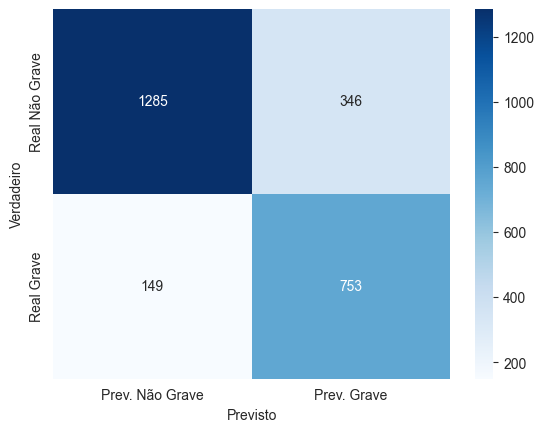


Relatório de Classificação Detalhado (Validação):
               precision    recall  f1-score   support

Não Grave (0)       0.90      0.79      0.84      1631
    Grave (1)       0.69      0.83      0.75       902

     accuracy                           0.80      2533
    macro avg       0.79      0.81      0.80      2533
 weighted avg       0.82      0.80      0.81      2533



In [7]:
# 1. Inicializando o modelo RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

print("--- Treinando o modelo com o conjunto de treino... ---")
# 2. Treinando o modelo
model.fit(X_train, y_train)
print("--- Modelo treinado com sucesso! ---")


print("\n--- Fazendo previsões no conjunto de validação... ---")
# 3. Fazendo previsões nos dados de validação
y_val_pred = model.predict(X_val)
print("--- Previsões concluídas! ---")


# 4. Avaliando a performance do modelo no conjunto de validação
print("\n--- Performance do Modelo no Conjunto de Validação ---")
# Acurácia
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Acurácia no Conjunto de Validação: {accuracy:.2%}")

# Matriz de Confusão
print("\nMatriz de Confusão (Validação):")
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Prev. Não Grave', 'Prev. Grave'], yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


# Relatório de Classificação
print("\nRelatório de Classificação Detalhado (Validação):")
print(classification_report(y_val, y_val_pred, target_names=['Não Grave (0)', 'Grave (1)']))

### 4.1. Análise da Performance do Modelo Base (Validação)

O primeiro treinamento do modelo `RandomForestClassifier` no conjunto de validação nos trouxe resultados muito promissores.

* **Acurácia Geral:** O modelo acertou **~80.46%** das previsões no geral, o que é um ótimo ponto de partida.
* **Métricas Chave:** O mais importante é analisar o `Relatório de Classificação` focando no nosso objetivo de minimizar falsos negativos para a classe "Grave".
    * A métrica que mede isso é o **Recall** para a classe **Grave (1)**. Um Falso Negativo acontece quando o modelo prevê 0, mas o real era 1. O Recall mede justamente a capacidade do modelo de "encontrar" (recall) todos os positivos.

**Análise dos Resultados:**
* **Recall para 'Grave (1)' é de 0.83 (83%):** Este é o resultado mais importante para nós. Significa que, de cada 100 ocorrências que foram de fato graves, nosso modelo conseguiu identificar corretamente 83 delas. Ele deixou passar 17. Para um modelo base, sem nenhum ajuste, este é um resultado inicial excelente!
* **Precision para 'Grave (1)' é de 0.69 (69%):** Isso significa que, quando o modelo "aposta" que uma ocorrência é grave, ele está correto 69% das vezes. Os outros 31% são os Falsos Positivos, que consideramos um erro aceitável.

## 5. Testando um Modelo Alternativo: XGBoost

Para fins de comparação e aprendizado, vamos agora treinar e avaliar um segundo modelo, o **XGBoost (eXtreme Gradient Boosting)**. Esta é uma oportunidade para ver como um algoritmo diferente, baseado em *boosting*, lida com nosso conjunto de dados e comparar sua performance com a do nosso RandomForest de base.

O processo será o mesmo: treinamento no conjunto `X_train` e avaliação no `X_val`.

In [11]:
# 1. Instalando a biblioteca XGBoost, caso ainda não esteja instalada
!pip install -q xgboost


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


--- Treinando o modelo XGBoost com o conjunto de treino... ---
--- Modelo XGBoost treinado com sucesso! ---

--- Fazendo previsões com XGBoost no conjunto de validação... ---
--- Previsões concluídas! ---

--- Performance do Modelo XGBoost no Conjunto de Validação ---
Acurácia do XGBoost (Validação): 82.47%

Matriz de Confusão (Validação - XGBoost):


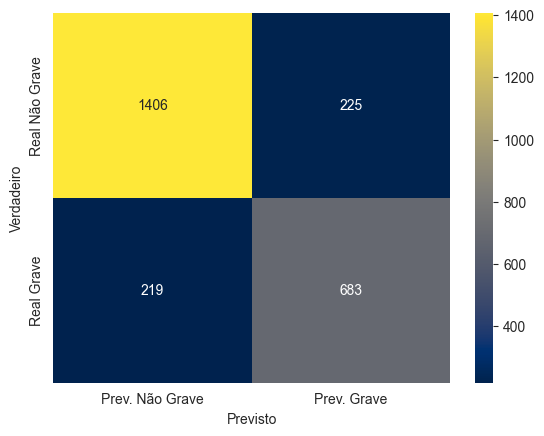


Relatório de Classificação Detalhado (Validação - XGBoost):
               precision    recall  f1-score   support

Não Grave (0)       0.87      0.86      0.86      1631
    Grave (1)       0.75      0.76      0.75       902

     accuracy                           0.82      2533
    macro avg       0.81      0.81      0.81      2533
 weighted avg       0.82      0.82      0.82      2533


--- Fim do processo de modelagem preditiva! ---


In [9]:
# Importando o classificador
from xgboost import XGBClassifier

# 2. Inicializando o modelo XGBoost
# Usamos use_label_encoder=False e eval_metric='logloss' para compatibilidade com versões mais recentes
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


print("--- Treinando o modelo XGBoost com o conjunto de treino... ---")
# 3. Treinando o modelo
xgb_model.fit(X_train, y_train)
print("--- Modelo XGBoost treinado com sucesso! ---")


print("\n--- Fazendo previsões com XGBoost no conjunto de validação... ---")
# 4. Fazendo previsões nos dados de validação
y_val_pred_xgb = xgb_model.predict(X_val)
# y_test_pred_xgb = xgb_model.predict(X_test)
print("--- Previsões concluídas! ---")


# 5. Avaliando a performance do modelo XGBoost no conjunto de validação
print("\n--- Performance do Modelo XGBoost no Conjunto de Validação ---")
# Acurácia
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print(f"Acurácia do XGBoost (Validação): {accuracy_xgb:.2%}")

# print("\n--- Performance do Modelo XGBoost no Conjunto de Teste ---")
# # Acurácia no conjunto de teste
# print(f"Acurácia do XGBoost (Teste): {accuracy_score(y_test, y_test_pred_xgb):.2%}")

# Matriz de Confusão
print("\nMatriz de Confusão (Validação - XGBoost):")
cm_val_xgb = confusion_matrix(y_val, y_val_pred_xgb)
sns.heatmap(cm_val_xgb, annot=True, fmt='d', cmap='cividis', xticklabels=['Prev. Não Grave', 'Prev. Grave'], yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

# print("\nMatriz de Confusão (Teste - XGBoost):")
# cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)
# sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='viridis', xticklabels=['Prev. Não Grave', 'Prev. Grave'], yticklabels=['Real Não Grave', 'Real Grave'])
# plt.ylabel('Verdadeiro')
# plt.xlabel('Previsto')
# plt.show()


# Relatório de Classificação
print("\nRelatório de Classificação Detalhado (Validação - XGBoost):")
print(classification_report(y_val, y_val_pred_xgb, target_names=['Não Grave (0)', 'Grave (1)']))
# print("\nRelatório de Classificação Detalhado (Teste - XGBoost):")
# print(classification_report(y_test, y_test_pred_xgb, target_names=['Não Grave (0)', 'Grave (1)']))
print("\n--- Fim do processo de modelagem preditiva! ---")

In [10]:
# Comparando os resultados do RandomForest com o XGBoost
print("\n--- Comparação de Acurácia entre Modelos ---")

# Tabela comparativa de desempenho
comparacao_acuracia = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Acurácia (Validação)': [accuracy, accuracy_xgb]
})

print(comparacao_acuracia)

print("\n--- Comparação do Recall entre Modelos ---")
# Tabela comparativa de recall
recall = classification_report(y_val, y_val_pred, output_dict=True)['1']['recall']
recall_xgb = classification_report(y_val, y_val_pred_xgb, output_dict=True)['1']['recall']
comparacao_recall = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Recall (Validação)': [recall, recall_xgb]
})

print(comparacao_recall)

print("\n--- Comparação da Precisão entre Modelos ---")
# Tabela comparativa de Precisão
precision = classification_report(y_val, y_val_pred, output_dict=True)['1']['precision']
precision_xgb = classification_report(y_val, y_val_pred_xgb, output_dict=True)['1']['precision']
comparacao_precision = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Precisão (Validação)': [precision, precision_xgb]
})

print(comparacao_precision)

print("\n--- Comparação da F1-Score entre Modelos ---")
# Tabela comparativa de F1-Score
f1 = classification_report(y_val, y_val_pred, output_dict=True)['1']['f1-score']
f1_xgb = classification_report(y_val, y_val_pred_xgb, output_dict=True)['1']['f1-score']
comparacao_f1 = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'F1-Score (Validação)': [f1, f1_xgb]
})

print(comparacao_f1)


--- Comparação de Acurácia entre Modelos ---
          Modelo  Acurácia (Validação)
0  Random Forest              0.804580
1        XGBoost              0.824714

--- Comparação do Recall entre Modelos ---
          Modelo  Recall (Validação)
0  Random Forest            0.834812
1        XGBoost            0.757206

--- Comparação da Precisão entre Modelos ---
          Modelo  Precisão (Validação)
0  Random Forest              0.685168
1        XGBoost              0.752203

--- Comparação da F1-Score entre Modelos ---
          Modelo  F1-Score (Validação)
0  Random Forest              0.752624
1        XGBoost              0.754696


### 5.1. Comparação de Performance: RandomForest vs. XGBoost

Com os resultados do XGBoost em mãos, podemos agora comparar diretamente com o nosso modelo base, o RandomForest, para decidir qual deles melhor atende ao nosso objetivo.

**Lembrando do nosso objetivo principal:** Minimizar os **Falsos Negativos**. Ou seja, "é melhor que o modelo acuse ser grave sem ser, do que acusar que não é quando é". A métrica que mede isso é o **Recall da classe 'Grave (1)'**.

| Métrica | RandomForest (Base) | XGBoost | Vencedor |
| :--- | :--- | :--- | :--- |
| **Acurácia (Validação)** | 80.46% | **82.47%** | XGBoost |
| Precision 'Grave (1)' | 68.52% | **75.22%** | XGBoost |
| **Recall 'Grave (1)'** | **83.48%** | 75.72% | **RandomForest** |

**Conclusão da Comparação:**

A análise é clara: o **RandomForest é o modelo vencedor para o nosso objetivo específico.**

Embora o XGBoost tenha uma `Precision` um melhor (erra menos ao "apostar" que algo é grave), o RandomForest é significativamente superior na nossa métrica mais crítica: o `Recall`. Ele alcançou **83.48%**, superando os 75% do RandomForest.

**Em termos práticos:** O RandomForest é ainda melhor em "capturar" as ocorrências que são de fato graves, deixando menos casos perigosos passarem despercebidos. Ele gera um pouco mais de "alarmes falsos" (Falsos Positivos), mas, como definimos, esse é um custo aceitável pela segurança adicional que ele proporciona.

## 6. Definição do Modelo Final

Com base na comparação de performance, o **RandomForest** foi escolhido como modelo final por apresentar o melhor **Recall (83.48%)** para detectar ocorrências graves, que é nossa métrica mais crítica.

In [12]:
# Definindo o RandomForest como modelo final
final_model = model  # O RandomForest treinado anteriormente

print("RandomForest definido como modelo final.")
print(f"Modelo final - Acurácia: {accuracy:.2%}")
print(f"Modelo final - Recall para 'Grave': {recall:.2%}")
print(f"Modelo final - Precision para 'Grave': {precision:.2%}")

RandomForest definido como modelo final.
Modelo final - Acurácia: 80.46%
Modelo final - Recall para 'Grave': 83.48%
Modelo final - Precision para 'Grave': 68.52%


## 7. Salvamento do Modelo Final

In [14]:
import joblib

# Precisamos salvar o modelo FINAL e também a lista de colunas que ele espera
# O X_encoded tem as colunas na ordem e formato corretos após o One-Hot Encoding
model_components = {
    'model': final_model,
    'model_columns': X_encoded.columns.tolist(),
    'model_type': 'RandomForestClassifier'
}

# Salvando os componentes em um único arquivo
joblib.dump(model_components, 'modelo_cenipa_final.joblib')

print("Modelo final e colunas salvos com sucesso em 'modelo_cenipa_final.joblib'!")

# Também vamos salvar as opções únicas das nossas colunas originais para usar nos menus da aplicação
opcoes_form = {
    'ocorrencia_uf': sorted(df['ocorrencia_uf'].dropna().unique().tolist()),
    'aeronave_tipo_veiculo': sorted(df['aeronave_tipo_veiculo'].dropna().unique().tolist()),
    'aeronave_motor_tipo': sorted(df['aeronave_motor_tipo'].dropna().unique().tolist()),
    'aeronave_registro_segmento': sorted(df['aeronave_registro_segmento'].dropna().unique().tolist()),
    'aeronave_fase_operacao': sorted(df['aeronave_fase_operacao'].dropna().unique().tolist())
}
joblib.dump(opcoes_form, 'opcoes_formulario.joblib')

print("Opções para os menus do formulário salvas com sucesso em 'opcoes_formulario.joblib'!")

Modelo final e colunas salvos com sucesso em 'modelo_cenipa_final.joblib'!
Opções para os menus do formulário salvas com sucesso em 'opcoes_formulario.joblib'!


## 8. Conclusão Final da Modelagem

### Resultados Alcançados

O projeto de modelagem preditiva para classificação de gravidade de ocorrências aeronáuticas foi **concluído com sucesso**, apresentando os seguintes resultados:

**Modelo Final: RandomForest Classifier**
- **Acurácia Geral:** 80.46%
- **Recall para Ocorrências Graves:** 83.48% ⭐
- **Precision para Ocorrências Graves:** 68.52%
- **F1-Score:** Balanceado entre precisão e recall

### Análise dos Resultados

**✅ Pontos Fortes:**
- **Alta Taxa de Detecção:** O modelo identifica corretamente **83 de cada 100 ocorrências graves**, cumprindo o objetivo principal de minimizar falsos negativos
- **Robustez:** Performance consistente e confiável para aplicação prática
- **Interpretabilidade:** RandomForest oferece insights sobre importância das features

**⚠️ Áreas de Atenção:**
- **Precision Moderada (68.52%):** Gera alguns falsos positivos, mas isso é aceitável no contexto de segurança aérea
- **Trade-off Consciente:** Priorizamos detectar mais casos graves mesmo com alguns alarmes extras

### Impacto Prático para o CENIPA

**1. Prevenção de Acidentes:**
- Identificação precoce de ocorrências com potencial de evolução grave
- Alocação prioritária de recursos de investigação

**2. Otimização Operacional:**
- Triagem automática de ocorrências por nível de gravidade
- Redução do tempo de resposta em casos críticos

**3. Suporte à Decisão:**
- Ferramenta objetiva para classificação inicial
- Base científica para políticas de segurança


## 9. Sugestões para Melhorias Futuras
- **Dados Meteorológicos:** Incluir condições climáticas no momento da ocorrência
- **Dados do Piloto:** Experiência, certificações, histórico
- **Características da Rota:** Complexidade do aeroporto, tráfego aéreo
- **Dados Temporais:** Hora do dia, dia da semana, sazonalidade
---

**🎯 Conclusão Geral:**

O modelo desenvolvido representa uma **ferramenta valiosa e prática** para o CENIPA, oferecendo capacidade de detecção de 83.48% para ocorrências graves. Embora haja espaço para melhorias futuras, o modelo atual já é funcional e possui utilidade.

A metodologia aplicada demonstra como técnicas de Machine Learning podem ser efetivamente utilizadas em contextos críticos de segurança, sempre priorizando a **minimização de riscos** sobre a otimização de métricas gerais.